# You might need a token for space itself?

# Do you need psuedo labels?

# Classification model with test as well in train? Will increase the vocab size as well?

## Settings

In [38]:
# CONTROLS
MODEL_PREFIX = "V04"
MODEL_NUMBER = MODEL_PREFIX[-2:]
TRAIN_SPLIT_RATIO = 0.8

DROPOUT = 0.1
MIN_LR = 1e-5
MAX_LR = 1e-3
BATCH_SIZE = 512
PREDICT_BATCH_SIZE = 2048
STEP_SIZE = 20
CLR_METHOD = "triangular2" # exp_range, triangular, triangular2
NUM_EPOCHS = 40

## Libraries

In [39]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.utils import class_weight

import pickle, os, sys

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Activation, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

%matplotlib inline

In [40]:
import spacy

In [41]:
#import os
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [42]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

## Import Data

In [43]:
df = pd.read_csv("../data/train.csv", dtype={"time":np.float64,"signal":np.float64,"open_channels":np.int16})
print(pd.concat((df.dtypes, df.isna().sum()), axis=1))
print(df.shape)

# Counts of various columns
print({i:df[i].nunique() for i in df.columns})
print(df.describe()) #.astype(int)
df.head(5)

                    0  1
textID         object  0
text           object  1
selected_text  object  1
sentiment      object  0
(27481, 4)
{'textID': 27481, 'text': 27480, 'selected_text': 22463, 'sentiment': 3}
            textID                                               text  \
count        27481                                              27480   
unique       27481                                              27480   
top     6bf46b99ce  is wondering y Mother Nature is making my life...   
freq             1                                                  1   

       selected_text sentiment  
count          27480     27481  
unique         22463         3  
top             good   neutral  
freq             199     11118  


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [44]:
test_df = pd.read_csv("../data/test.csv", dtype={"time":np.float64,"signal":np.float64})
print(pd.concat((test_df.dtypes, test_df.isna().sum()), axis=1))
print(test_df.shape)

# Counts of various columns
print({i:test_df[i].nunique() for i in test_df.columns})
print(test_df.describe())
test_df.head(5)

                0  1
textID     object  0
text       object  0
sentiment  object  0
(3534, 3)
{'textID': 3534, 'text': 3534, 'sentiment': 3}
            textID         text sentiment
count         3534         3534      3534
unique        3534         3534         3
top     fec3cae0c2   Great idea   neutral
freq             1            1      1430


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


## Exploration

#### Sentiment count in training

In [46]:
pd.concat([df.groupby("sentiment")[["text"]].count(), test_df.groupby("sentiment")[["text"]].count()], axis=1)

,text,text
sentiment,,
negative,7781,1001
neutral,11117,1430
positive,8582,1103


## Preprocessing

#### Cleaning

In [47]:
anomalous_idxs = [27302, 18, 27, 149, 160, 251, 295, 309, 398, 458, 492, 581, 637, 639, 678, 757, 787, 863, 1077, 1096, 1157, 1376, 1393, 1420, 1515, 1518, 1693, 1696, 1728, 1754, 1798, 1929, 2008, 2056, 2124, 2136, 2187, 2213, 2324, 2364, 2392, 2401, 2439, 2440, 2785, 2787, 2986, 3319, 3363, 3369, 3399, 3400, 3411, 3473, 4148, 4369, 4404, 4576, 4639, 4654, 4747, 5167, 5189, 5196, 5213, 5241, 5358, 5361, 5510, 5530, 5560, 5687, 5697, 5712, 5751, 6113, 6131, 6230, 6261, 6360, 6528, 6540, 6627, 6686, 6724, 6759, 6804, 6859, 6948, 6987, 7024, 7040, 7331, 7409, 7438, 7442, 7506, 7513, 7530, 7642, 7663, 7818, 7837, 8005, 8049, 8052, 8153, 8161, 8235, 8249, 8497, 8569, 8594, 8624, 8691, 8706, 8720, 8749, 8803, 8999, 9113, 9190, 9374, 9442, 9449, 9496, 9535, 9539, 9594, 9631, 9696, 9882, 10007, 10050, 10070, 10164, 10293, 10411, 10492, 10508, 10521, 10530, 10672, 10747, 10813, 10935, 10968, 10981, 10986, 11176, 11228, 11300, 11323, 11349, 11353, 11480, 11588, 11643, 11698, 11706, 11745, 11861, 11963, 11985, 12138, 12205, 12283, 12356, 12397, 12416, 12474, 12522, 12563, 12576, 12662, 12736, 12803, 12843, 12972, 12977, 13004, 13124, 13237, 13365, 13379, 13605, 13637, 13704, 13796, 13803, 13907, 13965, 13975, 14058, 14213, 14230, 14257, 14275, 14571, 14611, 14779, 14855, 14880, 15010, 15056, 15165, 15207, 15372, 15462, 15528, 15562, 15660, 15998, 16117, 16175, 16352, 16372, 16391, 16423, 16493, 16500, 16570, 16643, 16665, 16720, 16726, 16876, 16915, 17013, 17029, 17062, 17160, 17404, 17412, 17417, 17513, 17530, 17531, 17600, 17627, 17729, 17762, 17893, 17945, 17986, 18003, 18086, 18099, 18314, 18342, 18355, 18375, 18536, 18616, 18778, 18862, 18908, 18912, 18930, 18997, 19028, 19057, 19162, 19213, 19239, 19274, 19279, 19405, 19431, 19481, 19486, 19536, 19562, 19634, 19651, 19754, 19963, 19985, 19988, 20014, 20216, 20299, 20394, 20440, 20451, 20506, 20644, 20865, 20895, 21013, 21018, 21114, 21205, 21316, 21331, 21349, 21376, 21556, 21737, 21755, 21876, 21923, 22117, 22205, 22234, 22280, 22363, 22365, 22378, 22383, 22387, 22536, 22588, 22717, 22744, 22768, 22769, 22836, 22864, 22938, 23081, 23108, 23145, 23199, 23205, 23290, 23352, 23372, 23528, 23617, 23630, 23680, 23690, 23733, 23746, 23784, 23842, 23959, 24026, 24046, 24274, 24378, 24476, 24490, 24502, 24504, 24597, 24682, 24753, 24766, 24886, 24909, 24996, 25104, 25267, 25338, 25380, 25422, 25446, 25486, 25499, 25601, 25691, 25712, 25732, 25760, 25908, 25947, 25996, 26017, 26025, 26256, 26268, 26625, 26643, 26677, 26687, 26762, 26781, 26830, 26870, 26882, 26927, 27067, 27121, 27209, 27229, 27280, 27349, 27362, 27386, 27401]

In [48]:
df = df[(~df.index.isin(anomalous_idxs)) & (~df.selected_text.isna())].copy()

In [45]:
df["original_index"] = df.index
test_df["original_index"] = test_df.index

In [49]:
df["sentiment_code"] = df["sentiment"].astype("category")
X_sentiments = df["sentiment_code"].cat.codes.values

test_df["sentiment_code"] = test_df["sentiment"].astype("category")
X_sentiments_test = test_df["sentiment_code"].cat.codes.values

#### Tokenization

In [50]:
import re

In [51]:
from spacy.lang.en import English
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

In [52]:
#nlp = spacy.load('en_core_web_sm')

In [53]:
df["text"] = df["text"].astype(str)
df["selected_text"] = df["selected_text"].astype(str)
test_df["text"] = test_df["text"].astype(str)

In [54]:
df['text'] = df['text'].apply(lambda x: re.sub(pattern="`", repl=" ` ", string=x))
df['selected_text'] = df['selected_text'].apply(lambda x: re.sub(pattern="`", repl=" ` ", string=x))
test_df['text'] = test_df['text'].apply(lambda x: re.sub(pattern="`", repl=" ` ", string=x))

In [55]:
df['text_t'] = df['text'].apply(lambda x: tokenizer(x))
df['selected_text_t'] = df['selected_text'].apply(lambda x: tokenizer(x))
test_df['text_t'] = test_df['text'].apply(lambda x: tokenizer(x))

In [56]:
X_words = [[word.orth_ if not word.like_url else 'xxxURL' for word in row] for row in df['text_t']]
Y_words = [[word.orth_ if not word.like_url else 'xxxURL' for word in row] for row in df['selected_text_t']]
X_test_words = [[word.orth_ if not word.like_url else 'xxxURL' for word in row] for row in test_df['text_t']]

print(len(X_words), len(Y_words), len(X_test_words))

27088 27088 3534


In [57]:
list_of_words = set(sorted([j for i in X_words for j in i]))
Y_list_of_words = set(sorted([j for i in Y_words for j in i]))

In [58]:
vocab_itos = {i+1:j for i,j in enumerate(list_of_words)}
vocab_stoi = {j:i+1 for i,j in enumerate(list_of_words)}

vocab_stoi["xxxUNK"] = 0
vocab_itos[0] = "xxxUNK"

In [59]:
def get_from_vocab(vocab, word):
    try:
        value = vocab[word]
    except KeyError as k:
        value = 0
    return value

In [60]:
X = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words]
Y = [[get_from_vocab(vocab_stoi,j) for j in i] for i in Y_words]
Y2 = [[1 if j in y else 0 for j in X[i]] for i,y in enumerate(Y)]
X_test = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_test_words]

In [61]:
max_len = max([len(i) for i in X])
max_len_y = max([len(i) for i in Y2])
print(max_len, max_len_y)

106 106


#### Test Train split

In [62]:
np.random.seed(100)
idx = [i for i in np.arange(len(Y))]
np.random.shuffle(idx)
train_idx, val_idx = idx[:round(TRAIN_SPLIT_RATIO*len(Y))], idx[round(TRAIN_SPLIT_RATIO*len(Y)):]

print(len(idx), len(train_idx), len(val_idx), len(train_idx) + len(val_idx))

27088 21670 5418 27088


In [63]:
X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
X_sentiments_train, X_sentiments_val = [X_sentiments[i] for i in train_idx], [X_sentiments[i] for i in val_idx]
X_sentiments_train, X_sentiments_val = np.array(X_sentiments_train, dtype=np.int32), np.array(X_sentiments_val, dtype=np.int32)
Y_train, Y_val = [Y[i] for i in train_idx], [Y[i] for i in val_idx]
Y2_train, Y2_val = [Y2[i] for i in train_idx], [Y2[i] for i in val_idx]

[len(i) for i in [X_train, X_val, X_sentiments_train, X_sentiments_val, Y_train, Y_val, Y2_train, Y2_val]]

[21670, 5418, 21670, 5418, 21670, 5418, 21670, 5418]

#### Padding

In [64]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [65]:
X_train = pad_sequences(X_train, maxlen=max_len + 1, padding="post")
Y_train = pad_sequences(Y_train, maxlen=max_len + 1, padding="post")
Y2_train = pad_sequences(Y2_train, maxlen=max_len + 1, padding="post")

X_val = pad_sequences(X_val, maxlen=max_len + 1, padding="post")
Y_val = pad_sequences(Y_val, maxlen=max_len + 1, padding="post")
Y2_val = pad_sequences(Y2_val, maxlen=max_len + 1, padding="post")

X_test = pad_sequences(X_test, maxlen=max_len + 1, padding="post")

In [66]:
print(X_train.shape, X_sentiments_train.shape, X_val.shape, X_sentiments_val.shape, X_test.shape)
print(Y_train.shape, Y2_train.shape, Y_val.shape, Y2_val.shape)

(21670, 107) (21670,) (5418, 107) (5418,) (3534, 107)
(21670, 107) (21670, 107) (5418, 107) (5418, 107)


In [67]:
VOCAB_SIZE = len(vocab_stoi)

#### Checking for zero input vectors

In [68]:
keep_x_train = X_train.sum(axis=1) > 0
X_train, Y_train = X_train[keep_x_train], Y_train[keep_x_train]
X_sentiments_train, Y2_train = X_sentiments_train[keep_x_train], Y2_train[keep_x_train]

keep_x_val = X_val.sum(axis=1) > 0
X_val, Y_val = X_val[keep_x_val], Y_val[keep_x_val]
X_sentiments_val, Y2_val = X_sentiments_val[keep_x_val], Y2_val[keep_x_val]

keep_x_test = X_test.sum(axis=1) > 0
test_df["kept"] = keep_x_test
X_test, X_sentiments_test = X_test[keep_x_test], X_sentiments_test[keep_x_test]

In [69]:
print(np.argmax([X_train.sum(axis=1)==0]), np.min([X_train.sum(axis=1)]))
print(np.argmax([X_val.sum(axis=1)==0]), np.min([X_val.sum(axis=1)]))

0 1824
0 3262


## Model

In [70]:
from tensorflow.keras.layers import TimeDistributed

In [75]:
input_sentiment = Input((1))
input_sequences = Input((max_len+1))

emb_sequences = Embedding(input_dim=VOCAB_SIZE+1, input_length=max_len+1, output_dim=32, mask_zero=True)(input_sequences)

seq = Bidirectional(LSTM(16, activation='relu', return_sequences=True))(emb_sequences)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(16, activation='relu', return_sequences=True))(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

seq = TimeDistributed(Dense(16, activation="relu"))(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

seq = Flatten()(seq)

emb_sentiment = Embedding(input_dim=3, input_length=1, output_dim=5)(input_sentiment)
senti = Dense(8, activation="relu")(emb_sentiment)
senti = BatchNormalization()(senti)
senti = Dropout(DROPOUT)(senti)
senti = Flatten()(senti)

concat_layer = concatenate([senti, seq])
output = Dense(max_len+1, activation="sigmoid")(concat_layer)

In [76]:
model = Model([input_sentiment, input_sequences], output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 107)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 107, 32)      1017152     input_6[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 107, 32)      6272        embedding_4[0][0]                
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 107, 32)      128         bidirectional_4[0][0]            
____________________________________________________________________________________________

In [77]:
adam = Adam(learning_rate=MIN_LR)

model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=['accuracy'])

#model.compile(loss='sparse_categorical_crossentropy',
#              optimizer=adam) #, metrics=['accuracy']

In [78]:
#callbacks
mcp = ModelCheckpoint(filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
                      monitor='val_loss',
                      mode="auto",
                      save_weights_only=False,
                      save_best_only=True)

clr = CyclicLR(mode=CLR_METHOD,
               base_lr=MIN_LR,
               max_lr=MAX_LR,
               step_size= STEP_SIZE * (X_train.shape[0] // BATCH_SIZE))

In [79]:
history = model.fit(x=[X_sentiments_train, X_train],
                    y=Y2_train,
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=([X_sentiments_val, X_val], Y2_val),
                    verbose=1,
                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp, 

## Might need a callback as described here https://stackoverflow.com/questions/51728648/how-do-masked-values-affect-the-metrics-in-keras
#history = model.fit(x=[X_sentiments_train, X_train],
#                    y=Y_train,
#                    shuffle=True,
#                    batch_size=BATCH_SIZE,
#                    epochs=NUM_EPOCHS,
#                    validation_data=([X_sentiments_val, X_val], Y_val),
#                    verbose=1,
#                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp, 

Train on 21670 samples, validate on 5418 samples
Epoch 1/40
21670/21670 [==============================] - 33s 2ms/sample - loss: 0.7786 - accuracy: 0.5750 - val_loss: 0.6721 - val_accuracy: 0.6873
Epoch 2/40
21670/21670 [==============================] - 26s 1ms/sample - loss: 0.4154 - accuracy: 0.8229 - val_loss: 0.5797 - val_accuracy: 0.8785
Epoch 3/40
21670/21670 [==============================] - 25s 1ms/sample - loss: 0.2049 - accuracy: 0.9192 - val_loss: 0.4612 - val_accuracy: 0.9183
Epoch 4/40
21670/21670 [==============================] - 25s 1ms/sample - loss: 0.1525 - accuracy: 0.9259 - val_loss: 0.3693 - val_accuracy: 0.9183
Epoch 5/40
21670/21670 [==============================] - 25s 1ms/sample - loss: 0.1305 - accuracy: 0.9323 - val_loss: 0.3068 - val_accuracy: 0.9183
Epoch 6/40
21670/21670 [==============================] - 25s 1ms/sample - loss: 0.1150 - accuracy: 0.9406 - val_loss: 0.2626 - val_accuracy: 0.9187
Epoch 7/40
21670/21670 [==============================] -

## Validation

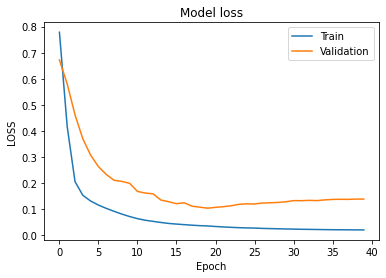

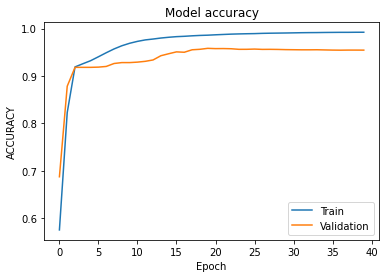

In [80]:
metric_names = ['loss' ,'accuracy']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

#### Inference

In [81]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
    compile=True
)

In [156]:
model.evaluate(x = [X_sentiments_val, X_val], y=Y2_val, batch_size=PREDICT_BATCH_SIZE)

5418/5418 [==============================] - 1s 191us/sample - loss: 0.1031 - accuracy: 0.9584


[0.10305292358716153, 0.95842004]

In [82]:
pred_train = model.predict(x = [X_sentiments_train, X_train], batch_size=PREDICT_BATCH_SIZE)
pred_val = model.predict(x = [X_sentiments_val, X_val], batch_size=PREDICT_BATCH_SIZE)
pred_test = model.predict(x = [X_sentiments_test, X_test], batch_size=PREDICT_BATCH_SIZE)

In [83]:
X_train.shape, Y_train.shape, pred_train.shape

((21670, 107), (21670, 107), (21670, 107))

#### Postprocessing

In [84]:
pred_train_words = [i[j>0.5].tolist() for i,j in zip(X_train, pred_train)]
pred_val_words = [i[j>0.5].tolist() for i,j in zip(X_val, pred_val)]
pred_test_words = [i[j>0.5].tolist() for i,j in zip(X_test, pred_test)]

In [121]:
# is it generally predicting words that are in itself??
np.mean([sum([1  if (k in j) else 0 for k in i])/len(i) if len(i)!=0 else 0 for i,j in zip(pred_val_words, Y_val)])

0.6021665168183049

In [ ]:
## Eyeball and check if preds make sense
#sent_labels = {i:j for i,j in enumerate(df.sentiment_code.cat.categories)}
#
#[(sent_labels[X_sentiments_val[num]], [get_from_vocab(vocab_itos,j) for j in i]) for num, i in enumerate(pred_val_words)]
#[(sent_labels[X_sentiments_test[num]], [get_from_vocab(vocab_itos,j) for j in i]) for num, i in enumerate(pred_test_words)]

In [142]:
pred_train_words = [[get_from_vocab(vocab_itos,j) for j in i] for i in pred_train_words]
pred_val_words = [[get_from_vocab(vocab_itos,j) for j in i] for i in pred_val_words]
pred_test_words = [[get_from_vocab(vocab_itos,j) for j in i] for i in pred_test_words]

In [143]:
from sklearn.metrics import jaccard_score

In [144]:
def jaccard(str1, str2):
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [145]:
len(train_idx), keep_x_train.shape, pred_train.shape

(21670, (21670,), (21670, 107))

In [146]:
predictions = pd.DataFrame({
    "pred_selected_text" : pred_train_words + pred_val_words,
    "original_index" : np.concatenate((np.array(train_idx, dtype=np.int64)[keep_x_train],
                                       np.array(val_idx, dtype=np.int64)[keep_x_val])),
    "set" : ["train" for i in range(sum(keep_x_train))] + ["val" for i in range(sum(keep_x_val))]
})

In [147]:
assert (predictions.original_index.min(), predictions.original_index.max()) == (df.original_index.min(), df.original_index.max())

AssertionError: 

In [150]:
print(df.shape, predictions.shape)
results = pd.merge(df, predictions, on = "original_index", how="inner")
print(df.shape, predictions.shape, results.shape)

(27088, 8) (27088, 3)
(27088, 8) (27088, 3) (26704, 10)


In [151]:
results.loc[results.set=="val"].head(10)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_t,selected_text_t,pred_selected_text,set
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,9,positive,"( , Journey, !, ?, Wow, ..., u, just, became, ...","(Wow, ..., u, just, became, cooler, .)",[],val
17,919fa93391,i ` ve been sick for the past few days and th...,sick,negative,17,negative,"(i, `, ve, been, sick, for, the, past, few, da...",(sick),[],val
26,6ce4a4954b,juss came backk from Berkeleyy ; omg its madd ...,fun,positive,28,positive,"(juss, came, backk, from, Berkeleyy, ;, omg, i...",(fun),"[I, Quite, ...., heavenly, isn, `, *, *, *, *, ?]",val
37,2863f435bd,A little happy for the wine jeje ok it ` sm my...,A little happy fo,positive,39,positive,"(A, little, happy, for, the, wine, jeje, ok, i...","(A, little, happy, fo)","[m, an, avid, fan, of, *, *, *, *, magazine, a...",val
38,d93afa85cf,"Car not happy, big big dent in boot! Hoping t...","Car not happy, big big dent in boot! Hoping th...",neutral,40,neutral,"( , Car, not, happy, ,, big, big, dent, in, bo...","(Car, not, happy, ,, big, big, dent, in, boot,...","[MAYDAY, ?, !]",val
42,c77717b103,I love to! But I ` m only available from 5pm....,I love to!,positive,44,positive,"( , I, love, to, !, But, I, `, m, only, availa...","(I, love, to, !)",[],val
43,a9d499e123,The girl in the hair salon asked me 'Shall I t...,The girl in the hair salon asked me 'Shall I t...,neutral,45,neutral,"(The, girl, in, the, hair, salon, asked, me, '...","(The, girl, in, the, hair, salon, asked, me, '...","[:, visiting, my, friendster, and, facebook]",val
58,52483f7da8,"i lost all my friends, i ` m alone and sleepy....","i lost all my friends, i ` m alone and sleepy..",negative,60,negative,"(i, lost, all, my, friends, ,, i, `, m, alone,...","(i, lost, all, my, friends, ,, i, `, m, alone,...",[],val
61,90a2cdb657,What better way to spoil mum than to let her k...,favorite,positive,63,positive,"(What, better, way, to, spoil, mum, than, to, ...",(favorite),"[Is, at, a, photoshoot, .]",val
70,04e2e334de,Anyone have an extra Keane ticket? I promise t...,Anyone have an extra Keane ticket? I promise t...,neutral,72,neutral,"(Anyone, have, an, extra, Keane, ticket, ?, I,...","(Anyone, have, an, extra, Keane, ticket, ?, I,...","[she, is, good, !, so, gor, -, juz, yea, i, kn...",val


In [ ]:
results.loc[results.set=="train"].head(10)

In [ ]:
conf_mat_train = confusion_matrix(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1))
conf_mat_val = confusion_matrix(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1))
print("The train accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_train)) / np.sum(conf_mat_train),2))
print("The valid accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_val)) / np.sum(conf_mat_val),2))

np.savetxt(X=conf_mat_train, fname="../results/ConfMatrix_train_" + MODEL_PREFIX + ".txt")
np.savetxt(X=conf_mat_val, fname="../results/ConfMatrix_val_" + MODEL_PREFIX + ".txt")

f1_train = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
f1_val = f1_score(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1), average='macro')
print("The train macro f1score is\t",np.round(f1_train,2))
print("The valid macro f1score is\t",np.round(f1_val,2))

In [ ]:
submission = pd.DataFrame({'time':test_df['time'],'open_channels':pred_test.reshape(-1)})
submission.to_csv("../results/submission_20200412V"+MODEL_NUMBER+".csv", index=False, float_format='%.4f')

In [ ]:
from tensorflow.keras.models import load_model

best_model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
    compile=True,
    custom_objects = {'macro_soft_f1':macro_soft_f1, 'macro_f1':macro_f1}
)

In [ ]:
pred_train = best_model.predict(x = X_train, batch_size=PREDICT_BATCH_SIZE)
pred_val = best_model.predict(x = X_val, batch_size=PREDICT_BATCH_SIZE)
pred_test = best_model.predict(x = X_test, batch_size=PREDICT_BATCH_SIZE)

In [ ]:
pred_train = pred_train.argmax(axis=1)
pred_val = pred_val.argmax(axis=1)
pred_test = pred_test.argmax(axis=1)

In [ ]:
conf_mat_train = confusion_matrix(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1))
conf_mat_val = confusion_matrix(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1))

print("The train accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_train)) / np.sum(conf_mat_train),2))
print("The valid accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_val)) / np.sum(conf_mat_val),2))

np.savetxt(X=conf_mat_train, fname="../results/BestConfMatrix_train_" + MODEL_PREFIX + ".txt")
np.savetxt(X=conf_mat_val, fname="../results/BestConfMatrix_val_" + MODEL_PREFIX + ".txt")

f1_train = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
f1_val = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
print("The train macro f1score is\t",np.round(f1_train,2))
print("The valid macro f1score is\t",np.round(f1_val,2))

In [ ]:
submission = pd.DataFrame({'time':test_df['time'],'open_channels':pred_test.reshape(-1)})
submission.to_csv("../results/best_submission_20200412V"+MODEL_NUMBER+".csv", index=False, float_format='%.4f')